In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. LOAD & PREPARE DATA
# -----------------------------------------------------------------------------
df = pd.read_csv("Iris.csv").drop(columns=["Id"])
# map species to integers: Setosa→0, Versicolor→1, Virginica→2
label_map = {sp: i for i, sp in enumerate(df["Species"].unique())}
X = df.drop(columns=["Species"]).to_numpy()         # shape (150, 4)
y = df["Species"].map(label_map).to_numpy()         # shape (150,)

# simple 80/20 train-test split
n = len(y)
idx = np.random.RandomState(42).permutation(n)
split = int(0.8 * n)
train_idx, test_idx = idx[:split], idx[split:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

Per-class F1: {np.int64(0): {'P': np.float64(1.0), 'R': np.float64(1.0), 'F1': np.float64(1.0), 'support': np.int64(7)}, np.int64(1): {'P': np.float64(0.7692307692307693), 'R': np.float64(0.9090909090909091), 'F1': np.float64(0.8333333333333333), 'support': np.int64(11)}, np.int64(2): {'P': np.float64(0.9), 'R': np.float64(0.75), 'F1': np.float64(0.8181818181818182), 'support': np.int64(12)}}
Macro-F1:    0.8838
Micro-F1:    0.8667
Weighted-F1: 0.8662


C:\Users\PLEXTEK\AppData\Local\Temp\ipykernel_12208\457493363.py:75: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tprs, fprs)


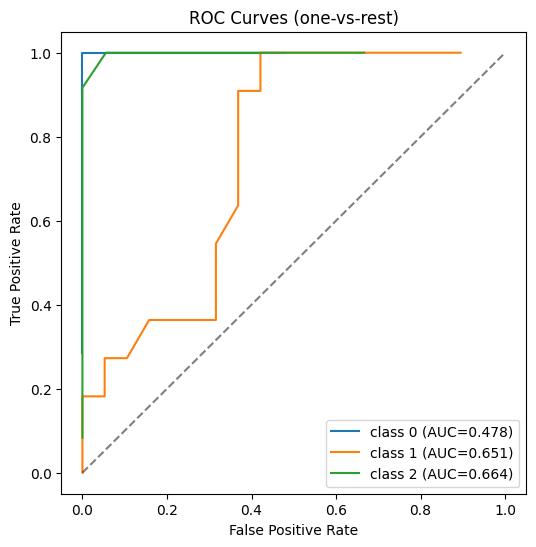

MAE: 0.1654, MSE: 0.0464, R²: inf


C:\Users\PLEXTEK\AppData\Local\Temp\ipykernel_12208\457493363.py:99: RuntimeWarning: divide by zero encountered in scalar divide
  r2  = 1 - np.sum((y - y_pred_all)*2) / np.sum((y - np.mean(y))*2)


In [ ]:
# -----------------------------------------------------------------------------
# 2. ONE-VS-REST LINEAR REGRESSION MODELS
# -----------------------------------------------------------------------------
# train 3 binary regressors: each predicts score for one class
models = {}
for cls in np.unique(y):
    # binary labels: positive for this class, negative otherwise
    y_bin = (y_train == cls).astype(float)
    # add bias column
    A = np.hstack([np.ones((len(X_train),1)), X_train])
    # normal equation: θ = (AᵀA)⁻¹ Aᵀ y
    theta = np.linalg.inv(A.T @ A) @ (A.T @ y_bin)
    models[cls] = theta

# get continuous “scores” on test set
A_test = np.hstack([np.ones((len(X_test),1)), X_test])
scores = np.column_stack([A_test @ models[cls] for cls in models])  
# predicted class = argmax score
y_pred = np.argmax(scores, axis=1)

# -----------------------------------------------------------------------------
# 3. F1-SCORES FROM SCRATCH
# -----------------------------------------------------------------------------
def confusion_counts(y_true, y_pred, cls):
    TP = np.sum((y_true==cls) & (y_pred==cls))
    FP = np.sum((y_true!=cls) & (y_pred==cls))
    FN = np.sum((y_true==cls) & (y_pred!=cls))
    TN = np.sum((y_true!=cls) & (y_pred!=cls))
    return TP, FP, FN, TN

def precision_recall_f1(y_true, y_pred):
    classes = np.unique(y_true)
    N = len(y_true)
    # per-class metrics
    per_class = {}
    for c in classes:
        TP, FP, FN, _ = confusion_counts(y_true, y_pred, c)
        prec = TP / (TP+FP) if TP+FP>0 else 0.0
        rec  = TP / (TP+FN) if TP+FN>0 else 0.0
        f1   = 2*prec*rec/(prec+rec) if prec+rec>0 else 0.0
        per_class[c] = {"P":prec, "R":rec, "F1":f1, "support":np.sum(y_true==c)}
    # micro: aggregate TP,FP,FN
    TP_tot = sum(confusion_counts(y_true,y_pred,c)[0] for c in classes)
    FP_tot = sum(confusion_counts(y_true,y_pred,c)[1] for c in classes)
    FN_tot = sum(confusion_counts(y_true,y_pred,c)[2] for c in classes)
    micro_f1 = 2*TP_tot / (2*TP_tot + FP_tot + FN_tot) if (2*TP_tot + FP_tot + FN_tot)>0 else 0.0
    # macro: mean of per-class F1
    macro_f1 = np.mean([per_class[c]["F1"] for c in classes])
    # weighted: support-weighted mean of per-class F1
    weights = np.array([per_class[c]["support"] for c in classes])
    f1s     = np.array([per_class[c]["F1"] for c in classes])
    weighted_f1 = np.sum(weights * f1s) / np.sum(weights)
    return per_class, macro_f1, micro_f1, weighted_f1

per_class, macro_f1, micro_f1, weighted_f1 = precision_recall_f1(y_test, y_pred)
print("Per-class F1:", per_class)
print(f"Macro-F1:    {macro_f1:.4f}")
print(f"Micro-F1:    {micro_f1:.4f}")
print(f"Weighted-F1: {weighted_f1:.4f}")

# -----------------------------------------------------------------------------
# 4. ROC CURVE & AUC FOR EACH ONE-VS-REST REGRESSOR
# -----------------------------------------------------------------------------
def roc_curve_and_auc(y_true_bin, score):
    # thresholds from 0 to 1
    thresholds = np.linspace(1,0,101)
    tprs, fprs = [], []
    for t in thresholds:
        y_pred_bin = (score >= t).astype(int)
        TP, FP, FN, TN = confusion_counts(y_true_bin, y_pred_bin, 1)
        TPR = TP / (TP+FN) if TP+FN>0 else 0
        FPR = FP / (FP+TN) if FP+TN>0 else 0
        tprs.append(TPR); fprs.append(FPR)
    # AUC via trapezoidal rule
    auc = np.trapz(tprs, fprs)
    return np.array(fprs), np.array(tprs), auc

plt.figure(figsize=(6,6))
for cls in models:
    y_true_bin = (y_test == cls).astype(int)
    fpr, tpr, auc = roc_curve_and_auc(y_true_bin, scores[:, cls])
    plt.plot(fpr, tpr, label=f"class {cls} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"k--",alpha=0.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (one-vs-rest)"); plt.legend(); plt.show()

# -----------------------------------------------------------------------------
# 5. NORMAL-EQUATION LINEAR REGRESSION ON MULTICLASS LABELS
# -----------------------------------------------------------------------------
# encode full y as numeric 0,1,2 and fit one multi-output regressor
A_all = np.hstack([np.ones((n,1)), X])
theta_all = np.linalg.inv(A_all.T @ A_all) @ (A_all.T @ y)   # shape (5,)

y_pred_all = A_all @ theta_all

# error metrics
mae = np.mean(np.abs(y - y_pred_all))
mse = np.mean((y - y_pred_all)**2)
r2  = 1 - np.sum((y - y_pred_all)*2) / np.sum((y - np.mean(y))*2)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")